<a href="https://colab.research.google.com/github/dmunozbe/TFM_DataScience/blob/main/Forecasting/05.%20Sarria-Sant%20Gervasi/Forecasting_(EsperanzaVida).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Forecasting**


1. [Importar bibliotecas](#Importar-bibliotecas)
2. [Carga de datos](#Carga-de-datos)
3. [Preparacion de los datos](#Preparacion-de-los-datos)
4. [Analisis por grupo de indicadores (Esperanza de vida)](#Analisis-por-grupo-de-indicadores-(esperanza-de-vida))
  - [Preparacion de datos](#Preparacion-de-datos)
  - [Analisis Exploratorio](#Analisis-Exploratorio)
  - [Modelo VAR](#Modelo-VAR)
  - [Modelo VARMAX](#Modelo-VARMAX)
5. [Conclusiones](#Conclusiones)



**Forecasting** es el proceso de predecir eventos futuros basados en patrones históricos y datos existentes.

El objetivo principal es el de hacer predicciones precisas sobre el futuro utilizando datos pasados y presentes y se utiliza en una amplia variaedad de constextos, como en finanzas, meteorologia, ventas entre otros

##Importar bibliotecas

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn import metrics


import warnings
warnings.filterwarnings("ignore")

##Carga de datos

In [2]:
# Cargar datos
data = pd.read_csv('/content/drive/MyDrive/UOC/TFM/Datasets definitivos/Final.csv')
data.head()

,Any,Trimestre,Mes,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Compraventa_Unitario,ParadosReg,Sin_Estudios,...,Internet,Movil,Index_Turisme,Index_Motos,Index_Ciclomotors,Index_Furgonetes,Index_Camions,Index_Resta,Zona Verde (m²),m² por habitante
0,2014,1,1,1,Ciutat Vella,1,el Raval,2813.0,4588,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,628919.0,6.2
1,2014,1,2,1,Ciutat Vella,1,el Raval,2813.0,4539,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,628919.0,6.2
2,2014,1,3,1,Ciutat Vella,1,el Raval,2813.0,4572,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,628919.0,6.2
3,2014,2,4,1,Ciutat Vella,1,el Raval,2948.8,4510,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,628919.0,6.2
4,2014,2,5,1,Ciutat Vella,1,el Raval,2948.8,4379,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,628919.0,6.2


In [3]:
print(data.dtypes)

Any                             int64
Trimestre                       int64
Mes                             int64
Codi_Districte                  int64
Nom_Districte                  object
Codi_Barri                      int64
Nom_Barri                      object
Compraventa_Unitario          float64
ParadosReg                      int64
Sin_Estudios                  float64
Solo_Estudios_Obligatorios    float64
Bachillerato                  float64
Estudios_Universitarios       float64
Estudios_Obligatorios         float64
ConsumIndustria               float64
ConsumResidencial             float64
ConsumServeis                 float64
Pm25                          float64
Pm10                          float64
Participacion                 float64
AñosEspVida                   float64
Internet                      float64
Movil                         float64
Index_Turisme                 float64
Index_Motos                   float64
Index_Ciclomotors             float64
Index_Furgon

##Preparacion de los datos

Ahora comprobamos cuantos valores NaN alberga el dataframe

In [4]:
data.isnull().sum()

Any                              0
Trimestre                        0
Mes                              0
Codi_Districte                   0
Nom_Districte                    0
Codi_Barri                       0
Nom_Barri                        0
Compraventa_Unitario             0
ParadosReg                       0
Sin_Estudios                  2409
Solo_Estudios_Obligatorios    2409
Bachillerato                  2409
Estudios_Universitarios       2409
Estudios_Obligatorios         2409
ConsumIndustria               4380
ConsumResidencial             4380
ConsumServeis                 4380
Pm25                          4161
Pm10                          4161
Participacion                    0
AñosEspVida                   3573
Internet                      2409
Movil                         2409
Index_Turisme                 5913
Index_Motos                   5913
Index_Ciclomotors             5913
Index_Furgonetes              5913
Index_Camions                 5913
Index_Resta         

El objetivo principal del TFM es analizar el valor de compraventa en la ciudad de Barcelona a partir de los indicadores de la ISO 37120.

Como serie temporal principal tenemos el valor de compraventa (unitario) por barrio desde 2014 hasta 2023 y por otro lado, tenemos las diferentes series temporales que corresponden a los indicadores.

Como se puede observar muchos de los indicadores obtenidos, tienen valores NaN. Esto se debe a que no hemos obtenido datos en el mismo rango de fechas que la serie principal. Este hecho limita el analisis de datos de forma global, ya que cada indicador tiene su casuistica.

Es por ello que se tendra que realizar el analisis por grupos de indicadores.

*   Paro
*   Estudios
*   Consumo de energia
*   Contaminacion
*   Participacion electoral
*   Esperanza de vida
*   Tecnologia
*   Indice Motor
*   Zonas Verdes

En un principio el estudio se realizara para toda la ciudad de Barcelona.

## Analisis por grupo de indicadores (Esperanza de vida)

### Preparacion de datos

In [5]:
df_sel = data[['Any','Trimestre','Mes','Codi_Districte','Nom_Districte','Codi_Barri','Nom_Barri','Compraventa_Unitario','AñosEspVida']]

In [6]:
df_var = df_sel.dropna()

In [7]:
df_var.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4968 entries, 0 to 5255
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Any                   4968 non-null   int64  
 1   Trimestre             4968 non-null   int64  
 2   Mes                   4968 non-null   int64  
 3   Codi_Districte        4968 non-null   int64  
 4   Nom_Districte         4968 non-null   object 
 5   Codi_Barri            4968 non-null   int64  
 6   Nom_Barri             4968 non-null   object 
 7   Compraventa_Unitario  4968 non-null   float64
 8   AñosEspVida           4968 non-null   float64
dtypes: float64(2), int64(5), object(2)
memory usage: 388.1+ KB


In [8]:
# Creamos la variable de fecha de la siguiente manera:
# Agregar un día fijo para cada mes, por ejemplo, el día 1
df_var['Fecha'] = pd.to_datetime(df_var['Any'].astype(str) + '-' + df_var['Mes'].astype(str) + '-1')

In [9]:
# Modificamos el indice del dataset por la fecha
df_varI = df_var.set_index('Fecha')

In [10]:
df_varI.head()

,Any,Trimestre,Mes,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Compraventa_Unitario,AñosEspVida
Fecha,,,,,,,,,
2014-01-01,2014,1,1,1,Ciutat Vella,1,el Raval,2813.0,80.7
2014-02-01,2014,1,2,1,Ciutat Vella,1,el Raval,2813.0,80.7
2014-03-01,2014,1,3,1,Ciutat Vella,1,el Raval,2813.0,80.7
2014-04-01,2014,2,4,1,Ciutat Vella,1,el Raval,2948.8,80.7
2014-05-01,2014,2,5,1,Ciutat Vella,1,el Raval,2948.8,80.7


### Analisis Exploratorio

Filtramos los datos por el distrito de Sarrià-Sant Gervasi -> Codi_Districte = 5

In [11]:
df_varFiltrado = df_varI[df_varI['Codi_Districte'] == 5]

In [12]:
# Agrupamos los datos
df =df_varFiltrado.drop(columns=['Any','Trimestre','Mes','Codi_Districte','Nom_Districte','Codi_Barri','Nom_Barri']).groupby('Fecha').mean()

In [13]:
df.head()

,Compraventa_Unitario,AñosEspVida
Fecha,,
2014-01-01,4198.150000,84.416667
2014-02-01,4198.150000,84.416667
2014-03-01,4198.150000,84.416667
2014-04-01,4246.083333,84.416667
2014-05-01,4246.083333,84.416667


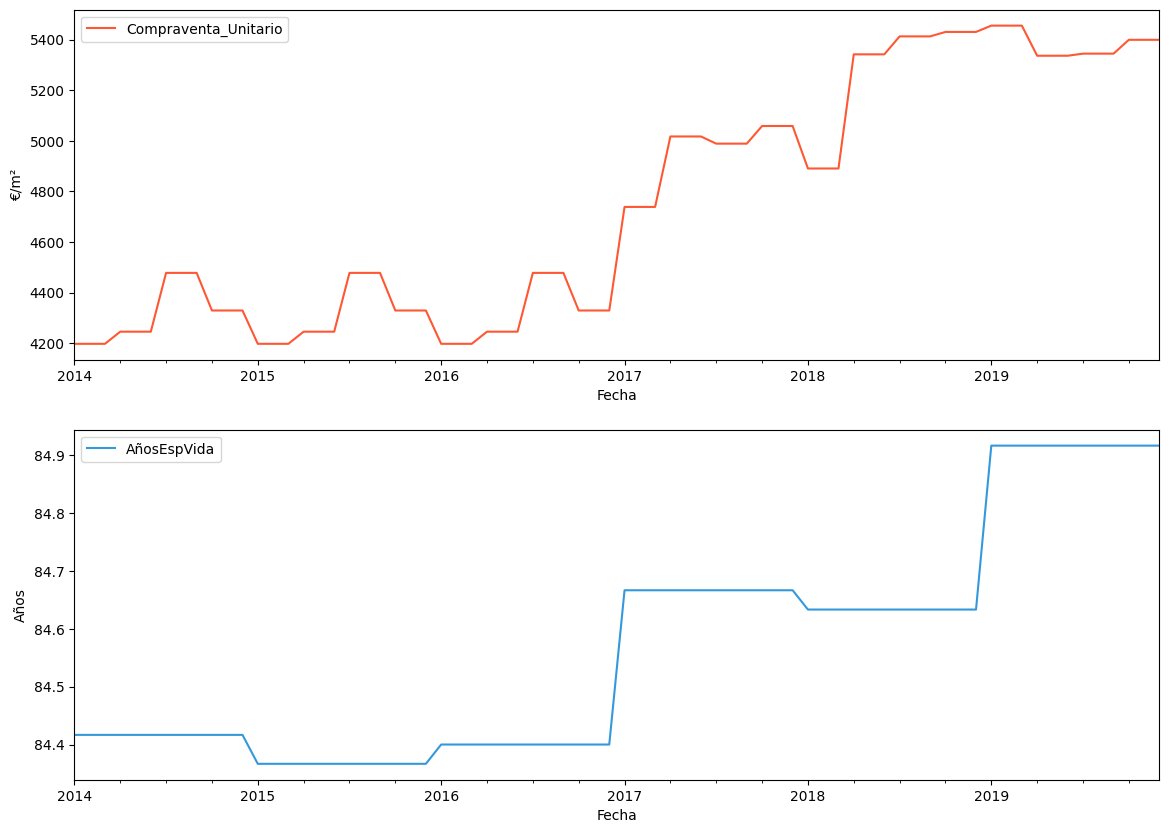

In [14]:
fig, axes = plt.subplots(nrows = int(len(df.columns)), ncols = 1, dpi = 100, figsize = (14,10))
unidades = ['€/m²', 'Años']
colores = ['#FF5733', '#3498DB']

for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df[col].plot(color = colores[i], legend = True, ax = ax)
    ax.set_ylabel(unidades[i])  # Establecer etiqueta del eje y
plt.show()

Cada una de las series tiene patrones de tendencia muy diferentes entre si

In [15]:
corr=df.corr()
corr

,Compraventa_Unitario,AñosEspVida
Compraventa_Unitario,1.000000,0.895532
AñosEspVida,0.895532,1.000000


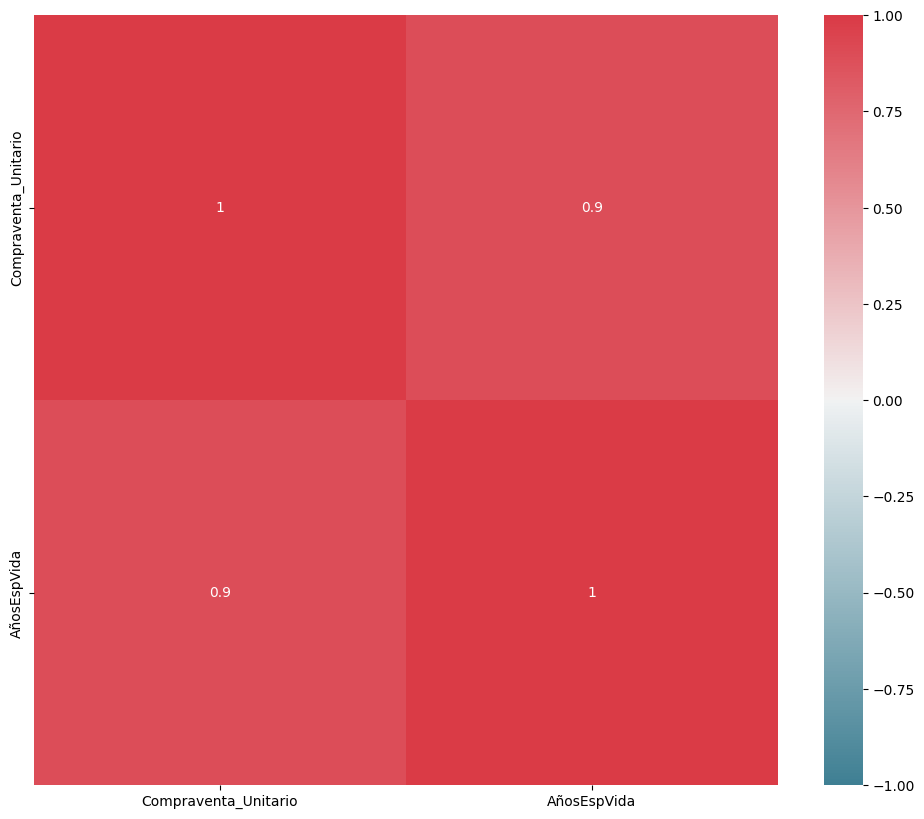

In [16]:
import seaborn as sb
fig, ax = plt.subplots(figsize=(12, 10))

sb.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True,vmax=1, vmin=-1, cmap =sb.diverging_palette(220, 10, as_cmap=True),center=0,ax=ax )
plt.show()

Tambien podemos observar como las 2 variables tienen un 63% de correlacion

### Modelo VAR

El modelo VAR es una extension del modelo ARIMA para multiples series temporales, es decir en vez de modelar una sola srie temporal, el VAR modela simultaneamente todas las series temporales de un sistema.
Cada serie temporal se regresa en función de usus propios valores pasados y de los valores pasados de las otras series temporales.
**Es util cuando las diferentes series temporales estan interrelacionadas y se influyen mutuamente.**




##### Dividir los datos en conjunto de Entrenamiento y Prueba


El modelo VAR se ajustará al conjunto de entrenamiento X_train y luego se utilizará el modelo para pronosticar las observaciones futuras. Estos pronósticos se compararán con los datos reales del conjunto de prueba.



---



In [17]:
fecha_division = '2019-01-01'

X_train, X_test = df[df.index<fecha_division], df[df.index>=fecha_division]
print(X_train.shape, X_test.shape)


(60, 2) (12, 2)


##### Prueba de estacionariedad

Necesitamos que los datos sean estacionarios para poder usar el modelo VAR. Vamos a averiguarlo haciendo un Test de Dickey-Fuller aumentado, a cada variable univariante que tiene nuestro dataset.

In [18]:
import statsmodels.tsa.stattools as sts

In [19]:
def augmented_dickey_fuller_statistics(time_series):
  result = sts.adfuller(time_series.values)
  print('p-value: %f' % result[1])

print('Test de Dickey-Fuller Aumentado:')
for i in range(len(X_train.columns)):
  print('Serie de tiempo',X_train.columns[i])
  augmented_dickey_fuller_statistics(X_train.iloc[:,i])

Test de Dickey-Fuller Aumentado:
Serie de tiempo Compraventa_Unitario
p-value: 0.913691
Serie de tiempo AñosEspVida
p-value: 0.790090


Los p-valores son mayores que 0.05, con lo cual no se rechaza la hipótesis nula de que la serie no es estacionaria. Habría que transformar los datos porque no se puede confirmar estacionariedad.

In [20]:
#Diferenciando por primera vez
X_train_transformed=X_train.diff().dropna()
X_train_transformed.head()

,Compraventa_Unitario,AñosEspVida
Fecha,,
2014-02-01,0.000000,0.0
2014-03-01,0.000000,0.0
2014-04-01,47.933333,0.0
2014-05-01,0.000000,0.0
2014-06-01,0.000000,0.0


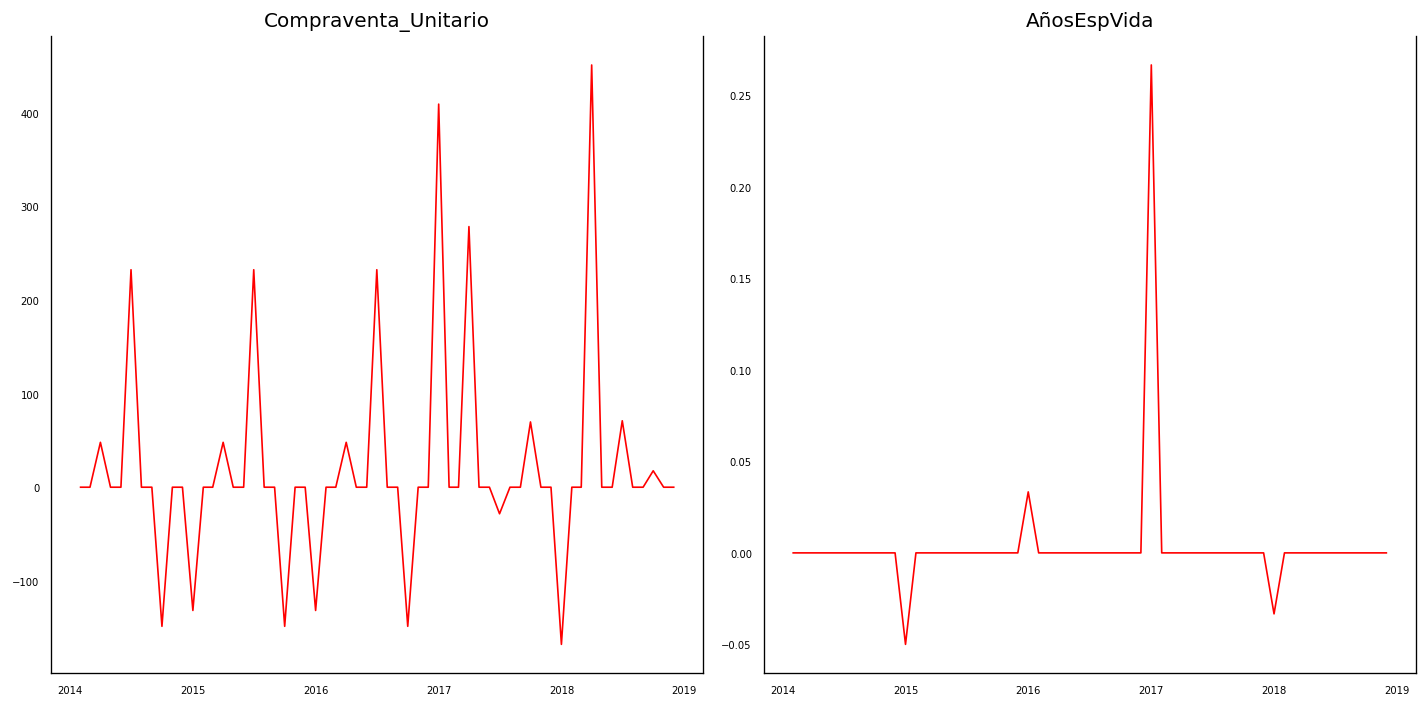

In [21]:
# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=120, figsize=(12,6))
for i, ax in enumerate(axes.flatten()):
    data = X_train_transformed[X_train_transformed.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(X_train_transformed.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [22]:
print('Test de Dickey-Fuller Aumentado 2da vez:')
for i in range(len(X_train_transformed.columns)):
  print('Serie de tiempo transformada', 'Variable', X_train_transformed.columns[i])
  augmented_dickey_fuller_statistics(X_train_transformed.iloc[:,i])

Test de Dickey-Fuller Aumentado 2da vez:
Serie de tiempo transformada Variable Compraventa_Unitario
p-value: 0.000000
Serie de tiempo transformada Variable AñosEspVida
p-value: 0.000000


Todos los p-valores son < 0.05 por lo tanto se podría concluir que con 2 ordenes de diferenciación se obtienen series estacionarias.

In [23]:
from statsmodels.tsa.api import VAR

In [24]:
model = VAR(X_train_transformed)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


#### Seleccionando el orden del modelo

Se establece un valor de 12 como número óptimo de rezagos, teniendo encuenta, que los datos de las dos series temporales parecen tener un ciclo anual es decir 12 meses

In [25]:
modelsel=model.select_order(12)
modelsel.summary()

,AIC,BIC,FPE,HQIC
0,2.834,2.912*,17.01,2.863*
1,3.002,3.238,20.13,3.091
2,3.170,3.563,23.84,3.318
3,3.138,3.689,23.15,3.345
4,3.305,4.013,27.50,3.571
5,3.472,4.338,32.76,3.797
6,3.471,4.495,33.14,3.856
7,3.636,4.817,39.75,4.081
8,3.801,5.139,47.91,4.305
9,3.809,5.305,49.73,4.372


#### Ajustando el modelo

In [26]:
res = model.fit(maxlags=12, ic='aic')
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 04, May, 2024
Time:                     16:15:05
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    4.35246
Nobs:                     47.0000    HQIC:                   3.12488
Log likelihood:          -139.409    FPE:                    13.8433
AIC:                      2.38421    Det(Omega_mle):         5.89889
--------------------------------------------------------------------
Results for equation Compraventa_Unitario
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                           31.012920        26.321057            1.178           0.239
L1.Compraventa_Unitario         -0.081386         0.220282           -0.369           0.712
L

In [27]:
X_train.columns

Index(['Compraventa_Unitario', 'AñosEspVida'], dtype='object')

###### Causalidad de Granger

In [28]:
grangercaus=res.test_causality(['AñosEspVida'],['Compraventa_Unitario'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
0.9155,1.980,0.540,"(12, 44)"


In [29]:
grangercaus=res.test_causality(['Compraventa_Unitario'],['AñosEspVida'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
0.9665,1.980,0.494,"(12, 44)"


Como se puede observar, la causalidad de Granger nos indica que ninguna de las series temporales puede predecir la otra serie temporal

###### Matriz de causalidad de Granger


In [30]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
warnings.filterwarnings("ignore")
maxlag=12
test = 'ssr_chi2test'
def grangers_causality_matrix(X_train_transformed, variables, test = 'ssr_chi2test', verbose=False):
  dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
  for c in dataset.columns:
    for r in dataset.index:
      test_result = grangercausalitytests(X_train_transformed[[r,c]], maxlag=maxlag, verbose=False)
      p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
      if verbose:
        print(f'Y = {r}, X = {c}, P Values = {p_values}')
      min_p_value = np.min(p_values)
      dataset.loc[r,c] = min_p_value
  dataset.columns = [var + '_x' for var in variables]
  dataset.index = [var + '_y' for var in variables]
  return dataset
grangers_causality_matrix(X_train_transformed, variables = X_train_transformed.columns)

,Compraventa_Unitario_x,AñosEspVida_x
Compraventa_Unitario_y,1.000,0.0159
AñosEspVida_y,0.024,1.0000


Con esta matriz queda claro que la serie temporal de Compraventa_Unitario no causa ni es causada por la otra serie temporal de ParadosReg

###### Diagnosis del modelo


###### Residuos

In [31]:
residuals=res.resid

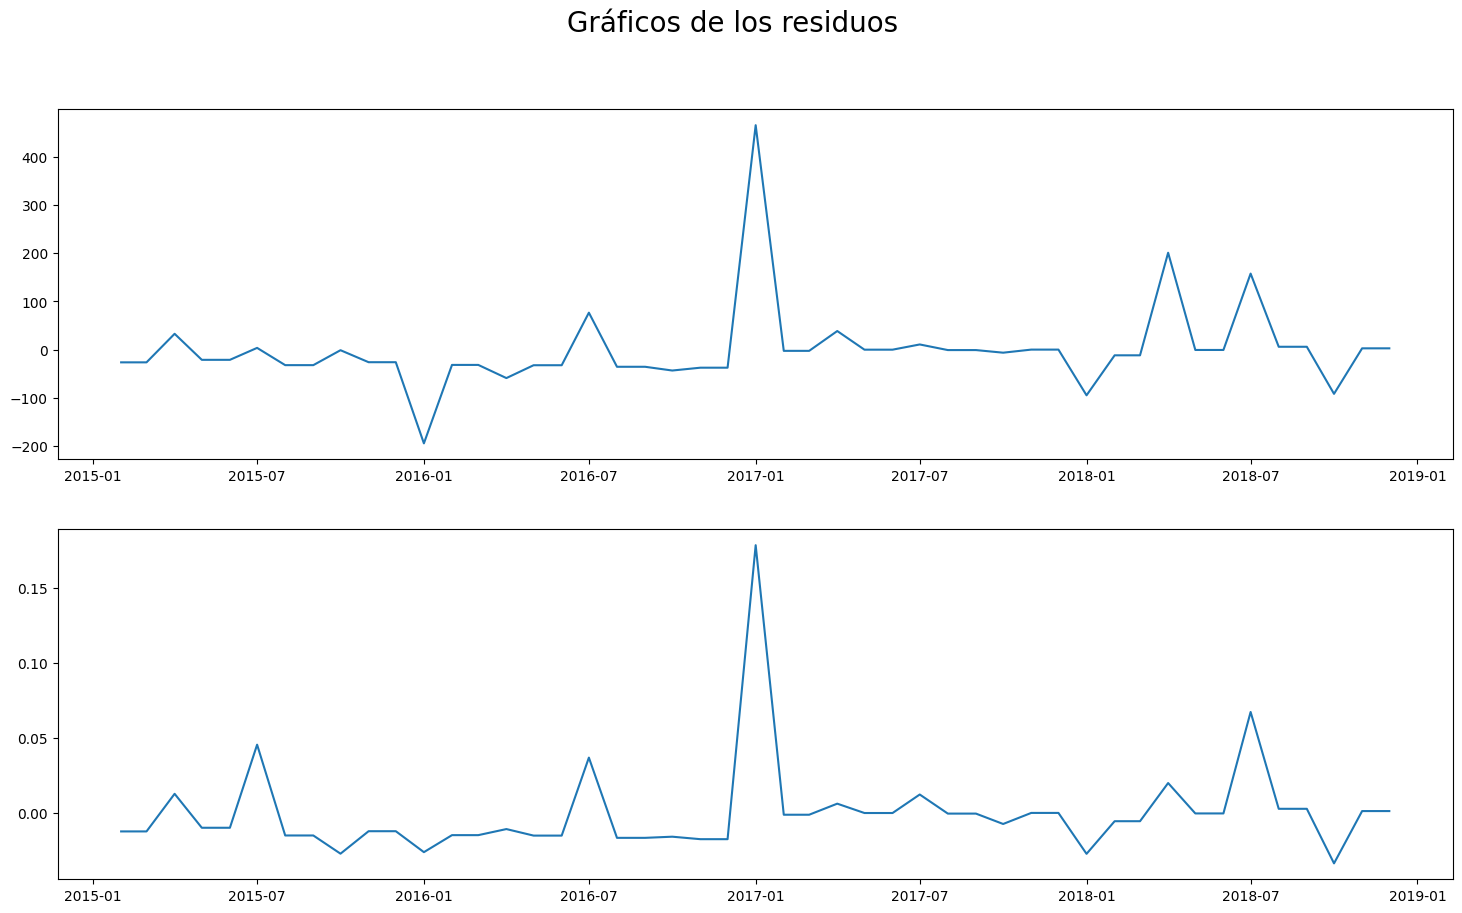

In [32]:
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los residuos',fontsize=20)
fig.set_size_inches(18, 10)
[axs[i].plot(residuals.iloc[:,i]) for i in range(2)]
plt.show()

###### Dickey - Fuller a los residuos


In [33]:
print('ADF de los Residuos, p-valores:')
[sts.adfuller(residuals.iloc[:,i])[1] for i in range(2)]

ADF de los Residuos, p-valores:


[4.922232887193465e-09, 1.2213092045489763e-09]

Todos los p-valores son < 0.1 por tanto se rechaza la hipótesis nula de que las 2 series de residuos no son estacionarias, por lo cual con un 90% de confianza se cree que son estacionarias.



###### ACF de los Residuos


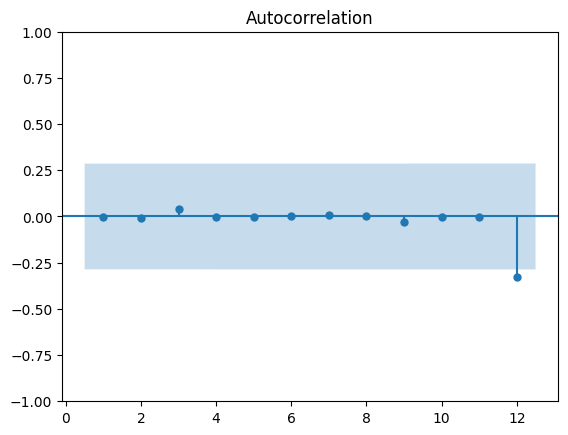

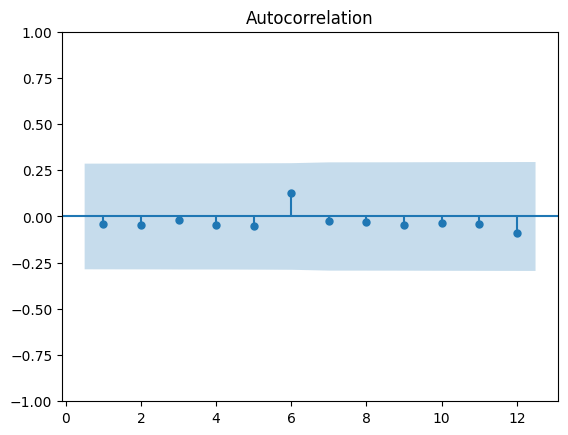

In [34]:
import statsmodels.graphics.tsaplots as sgt
[sgt.plot_acf(residuals.iloc[:,i], zero = False, lags = 12) for i in range(2)]
plt.show()

Conclusión: Los residuos del modelo no presentan estructura de autocorrelación, son estacionarios según los resultados de la prueba de Dickey - Fuller aumentada y en los gráficos se puede comprobar esto visualmente, entonces puede concluirse que son ruido blanco como es deseable.



#### Valores predichos


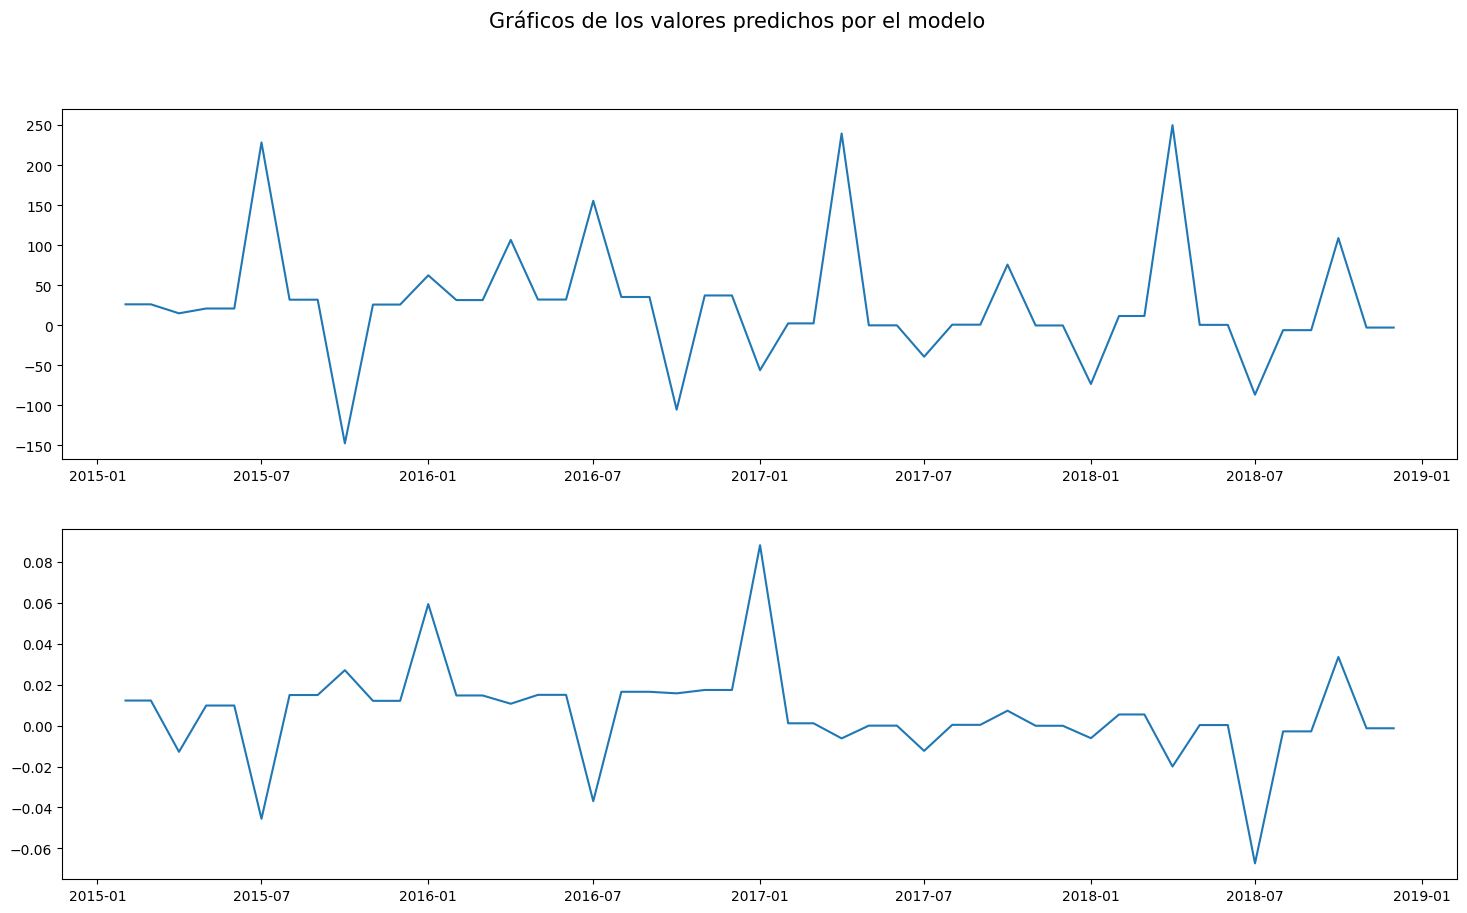

In [35]:
y_fitted = res.fittedvalues
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los valores predichos por el modelo',fontsize=15)
fig.set_size_inches(18, 10)
[axs[i].plot(y_fitted.iloc[:,i]) for i in range(2)]
plt.show()

#### Pronósticos a futuro


Para pronosticar, al modelo VAR le podemos pasar hasta el número de orden de retraso de observaciones de los datos pasados. Esto se debe a que los términos en el modelo VAR son esencialmente los retrasos de las diversas series de tiempo en el conjunto de datos, por lo que debemos proporcionar tantos valores anteriores como lo indique el orden de retraso utilizado por el modelo. De lo contrario estaríamos introduciendo poca fiabilidad.



In [36]:
# Obtener el orden del modelo
lag_order = res.k_ar
print('Orden del modelo:', lag_order)
# Input data para hacer forecasting (pronósticos a futuro)
input_data = X_train_transformed.values[-lag_order:]
# Forecasting
pred = res.forecast(y=input_data, steps=12)
pred = (pd.DataFrame(pred, index=X_test.index, columns=X_test.columns + '_pred'))
print('Predicciones:')
pred

Orden del modelo: 12
Predicciones:


,Compraventa_Unitario_pred,AñosEspVida_pred
Fecha,,
2019-01-01,-61.996196,0.012768
2019-02-01,-15.231475,-0.007111
2019-03-01,-14.445244,-0.006744
2019-04-01,396.970860,-0.067114
2019-05-01,-10.832605,-0.002707
2019-06-01,-10.338035,-0.002598
2019-07-01,-97.915713,-0.082587
2019-08-01,0.842514,-0.002308
2019-09-01,0.982644,-0.002094


<Figure size 1200x1000 with 0 Axes>

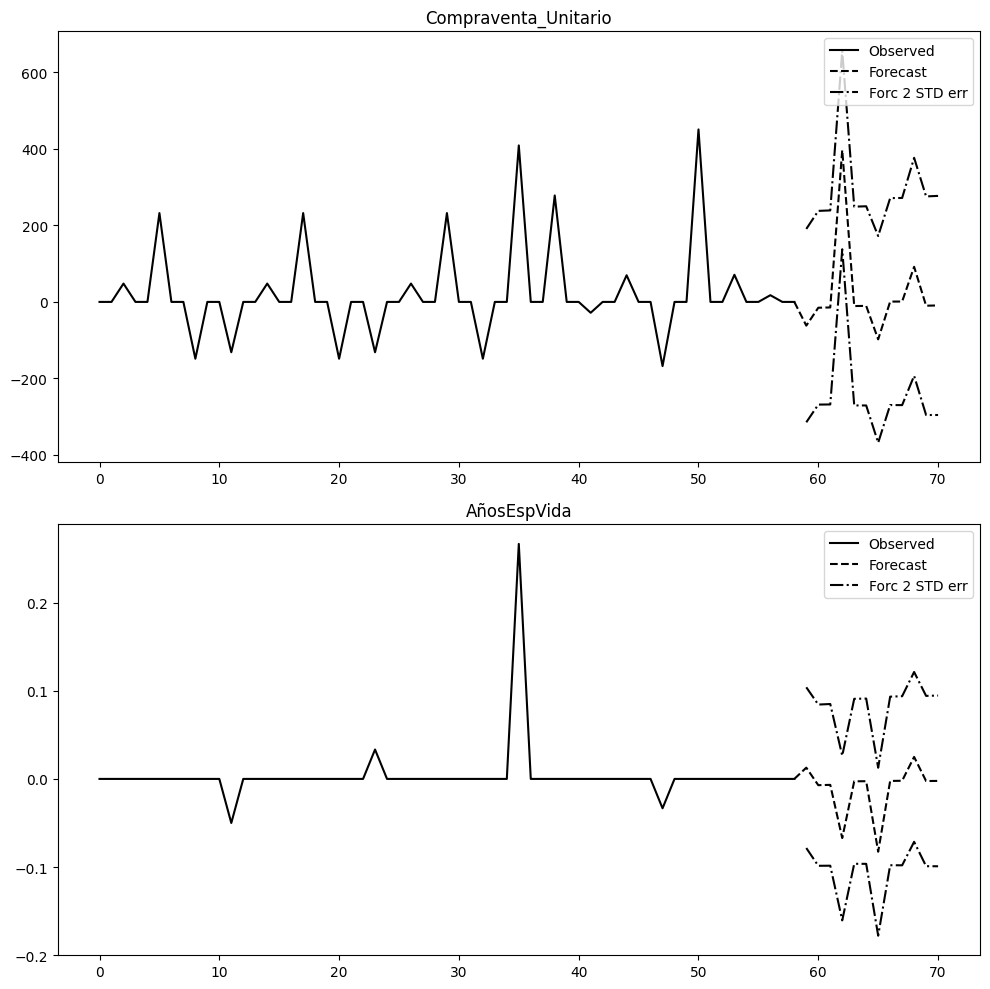

In [37]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 10))
res.plot_forecast(lag_order)
plt.tight_layout(h_pad = 1.15)
plt.show()


#### Invirtiendo la transformación de los pronósticos a la escala original


Los pronósticos se generan en la escala de los datos de entrenamiento utilizados por el modelo, es decir, son datos transformados. Entonces, para volver a ponerlos en su escala original, necesitamos des-diferenciarlos. La forma de invertir la diferenciación es sumar estas diferencias consecutivamente al número base. Una forma sencilla de hacerlo es determinar primero la suma acumulada y luego sumarla al número base. Este proceso se puede revertir agregando la observación en el paso de tiempo anterior al difference value. inverted(ts) = differenced(ts) + observation(ts-1)



In [38]:
# Invirtiendo la transformación teniendo en cuenta que hemos diferenciado dos veces
def invert_transformation(ds, df_forecast, second_diff=False):
    for col in ds.columns:
        # Undo the 2nd Differencing
        if second_diff:
            df_forecast[str(col)] = (ds[col].iloc[-1] - ds[col].iloc[-2]) + df_forecast[str(col)].cumsum()

        # Undo the 1st Differencing
        df_forecast[str(col)] = ds[col].iloc[-1] + df_forecast[str(col)].cumsum()

    return df_forecast

In [39]:
pred.columns=X_test.columns
output = invert_transformation(X_train, pred, second_diff=False)
output

,Compraventa_Unitario,AñosEspVida
Fecha,,
2019-01-01,5368.270471,84.646101
2019-02-01,5353.038996,84.638991
2019-03-01,5338.593751,84.632247
2019-04-01,5735.564612,84.565134
2019-05-01,5724.732007,84.562426
2019-06-01,5714.393972,84.559829
2019-07-01,5616.478259,84.477242
2019-08-01,5617.320773,84.474934
2019-09-01,5618.303417,84.472840


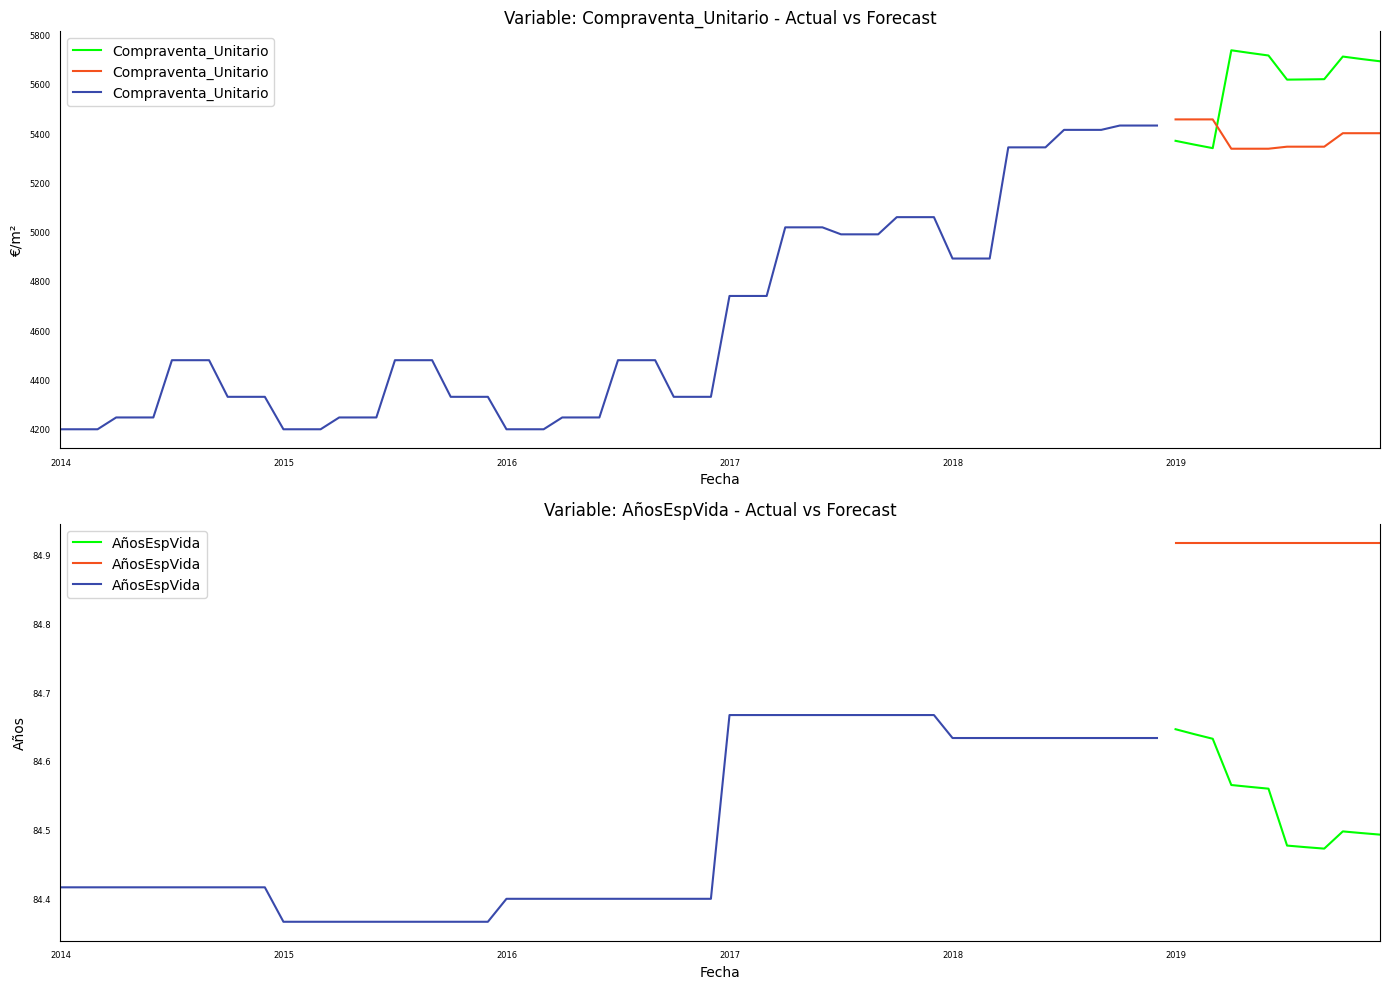

In [40]:
# Actual vs Forecasted Plots
fig, axes = plt.subplots(nrows = int(len(X_train.columns)), ncols = 1, dpi = 100, figsize = (14,10))
mi_lista = ['€/m²', 'Años']

for i, (col,ax) in enumerate(zip(X_train.columns, axes.flatten())):
    output[col].plot(color = '#00FF00', legend = True, ax = ax).autoscale(axis =' x',tight = True)
    X_test[col].plot(color = '#F4511E', legend = True, ax = ax)
    X_train[col].plot(color = '#3949AB', legend = True, ax = ax)

    ax.set_title('Variable: ' + col + ' - Actual vs Forecast')
    ax.set_ylabel(mi_lista[i])  # Establecer etiqueta del eje y
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)

plt.tight_layout()
plt.savefig('actual_forecast.png')
plt.show()

#### Evaluando el modelo


In [41]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [42]:
for i in ['Compraventa_Unitario','AñosEspVida']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(X_test[str(i)] , output[str(i)])

Evaluation metric for Compraventa_Unitario
Evaluation metric results:-
MSE is : 81731.14955809923
MAE is : 266.1604566534249
RMSE is : 285.886602620863
MAPE is : 4.958963933307
R2 is : -34.78261461458675

Evaluation metric for AñosEspVida
Evaluation metric results:-
MSE is : 0.14375556224026734
MAE is : 0.37365710809674013
RMSE is : 0.37915110739686275
MAPE is : 0.4400279977586733
R2 is : -7.118430654688339e+26



In [44]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('Mean absolute error:', mean_absolute_error(X_test, output))
print('Root mean squared error:', np.sqrt(mean_squared_error(X_test, output)))

Mean absolute error: 133.2670568807608
Root mean squared error: 202.15253314472895


### Modelo VARMAX (Auto Arima)

El modelo VARMAX es una extension del modelo VAR que permite incorporar variebles exogenas, es decir, varibales externas que pueden afectar a las series temporales del sistema, es decir, que ademas de modelar la dependencia entre las variables del sistema, el VARMAX tambien puede capturar la influencia de variables externas sobre las series temporales.

In [45]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.8 MB/s eta 0:00:00


#### Dividir los datos en conjuntos de Entrenamiento Y Prueba

In [46]:
fecha_division = '2019-01-01'

X_train, X_test = df[df.index<fecha_division], df[df.index>=fecha_division]
print(X_train.shape, X_test.shape)

(60, 2) (12, 2)


#### Prueba de estacionariedad

Necesitamos que los datos sean estacionarios para poder usar el modelo VAR. Vamos a averiguarlo haciendo un Test de Dickey-Fuller aumentado, a cada variable univariante que tiene nuestro dataset.

In [47]:
def augmented_dickey_fuller_statistics(time_series):
  result = sts.adfuller(time_series.values)
  print('p-value: %f' % result[1])

print('Test de Dickey-Fuller Aumentado:')
for i in range(len(X_train.columns)):
  print('Serie de tiempo',X_train.columns[i])
  augmented_dickey_fuller_statistics(X_train.iloc[:,i])

Test de Dickey-Fuller Aumentado:
Serie de tiempo Compraventa_Unitario
p-value: 0.913691
Serie de tiempo AñosEspVida
p-value: 0.790090


Los p-valores son mayores que 0.05, con lo cual no se rechaza la hipótesis nula de que la serie no es estacionaria. Habría que transformar los datos porque no se puede confirmar estacionariedad.

In [48]:
#Diferenciando por primera vez
X_train_transformed=X_train.diff().dropna()
X_train_transformed.head()

,Compraventa_Unitario,AñosEspVida
Fecha,,
2014-02-01,0.000000,0.0
2014-03-01,0.000000,0.0
2014-04-01,47.933333,0.0
2014-05-01,0.000000,0.0
2014-06-01,0.000000,0.0


In [49]:
print('Test de Dickey-Fuller Aumentado 2da vez:')
for i in range(len(X_train_transformed.columns)):
  print('Serie de tiempo transformada', 'Variable', X_train_transformed.columns[i])
  augmented_dickey_fuller_statistics(X_train_transformed.iloc[:,i])

Test de Dickey-Fuller Aumentado 2da vez:
Serie de tiempo transformada Variable Compraventa_Unitario
p-value: 0.000000
Serie de tiempo transformada Variable AñosEspVida
p-value: 0.000000


Todos los p-valores son < 0.05 por lo tanto se podría concluir que con 2 ordenes de diferenciación se obtienen series estacionarias.

####Test de Cointegracion

Determinaremos si las dos variables estan relacionadas entre si y si esa relacion es duradera o no

In [50]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df):
    res = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]
    def adjust(val, length= 6):
        return str(val).ljust(length)
    print('Column Name   >  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), '> ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [51]:
cointegration_test(X_train_transformed[['Compraventa_Unitario', 'AñosEspVida']])

Column Name   >  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Compraventa_Unitario >  23.32     > 12.3212   =>   True
AñosEspVida >  6.54      > 4.1296    =>   True


El test ha sido satisfactorio.

#### Ajustando el modelo

#####Auto Arima

Aplicaremos autoarima, para determinar los valores de p, q y d

In [52]:
import pmdarima as pm

In [53]:

pq = []
for name in ['Compraventa_Unitario', 'AñosEspVida']:
    print(f'Searching order of p and q for : {name}')
    # Ajusta un modelo ARIMA para cada columna
    stepwise_model = pm.auto_arima(X_train_transformed[name],
                                start_p=0, start_q=0,
                                max_p=4, max_q=4,
                                seasonal=False,
                                trace=True,
                                error_action='ignore',
                                suppress_warnings=True,
                                stepwise=True,
                                maxiter=1000)
    # Obtiene los parámetros óptimos de p y q del modelo
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    # Agrega los parámetros óptimos a la lista pq
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : Compraventa_Unitario
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=727.557, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=729.557, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=729.557, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=731.557, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=727.517, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=729.443, Time=0.20 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=729.437, Time=0.41 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=731.437, Time=0.66 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.785 seconds
optimal order for:Compraventa_Unitario is: (0, 0, 0) 


Searching order of p and q for : AñosEspVida
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-223.314, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-221.314, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[0]       

#####Seleccion del modelo

In [54]:
def inverse_diff(actual_df, pred_df, second_diff=False):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns:
        if second_diff:
          df_res[str(col)] = (actual_df[col].iloc[-1]- actual_df[col].iloc[-2]) + df_res[str(col)].cumsum()

        df_res[str(col)] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
    return df_res

In [55]:
pq

[(0, 0, 0), (0, 0, 0)]

In [56]:
from statsmodels.tsa.statespace.varmax import VARMAX

In [57]:
df_results_moni = pd.DataFrame(columns=['p', 'q','RMSE Compraventa_Unitario','RMSE AñosEspVida'])
print('Grid Search Started')
for i in pq:
    if i[0]== 0 and i[2] ==0:
        pass
    else:
        print(f' Running for {i}')
        model = VARMAX(X_train_transformed[['Compraventa_Unitario', 'AñosEspVida']], order=(i[0],i[2])).fit( disp=False)
        result = model.forecast(steps = 12)
        inv_res = inverse_diff(df[['Compraventa_Unitario', 'AñosEspVida']] , result, False)
        Comprarmse = np.sqrt(metrics.mean_squared_error(X_test['Compraventa_Unitario'], inv_res.Compraventa_Unitario))
        Paradosrmse = np.sqrt(metrics.mean_squared_error(X_test['AñosEspVida'], inv_res.AñosEspVida))
        #df_results_moni = df_results_moni.append({'p': i[0], 'q': i[2], 'RMSE Compraventa_Unitario':Comprarmse,'RMSE ParadosReg':Paradosrmse }, ignore_index=False)
        df_results_moni.loc[len(df_results_moni)] = [i[0], i[2], Comprarmse, Paradosrmse]


Grid Search Started


In [58]:
df_results_moni.sort_values(by = ['RMSE Compraventa_Unitario','RMSE AñosEspVida'] )

,p,q,RMSE Compraventa_Unitario,RMSE AñosEspVida


#### Pronósticos a futuro


In [59]:
model = VARMAX(X_train_transformed[['Compraventa_Unitario','AñosEspVida']], order=(0,2)).fit(disp=False)
result = model.forecast(steps = 12)

In [60]:
result

,Compraventa_Unitario,AñosEspVida
2019-01-01,22.883306,0.004101
2019-02-01,21.804389,0.003867
2019-03-01,20.883336,0.003658
2019-04-01,20.883336,0.003658
2019-05-01,20.883336,0.003658
2019-06-01,20.883336,0.003658
2019-07-01,20.883336,0.003658
2019-08-01,20.883336,0.003658
2019-09-01,20.883336,0.003658
2019-10-01,20.883336,0.003658


#### Invertiendo la transformacion de los pronosticos a la escala original

In [61]:
res = inverse_diff(df[['Compraventa_Unitario', 'AñosEspVida']],result,False)

In [62]:
res

,Compraventa_Unitario,AñosEspVida
2019-01-01,5422.049972,84.920768
2019-02-01,5443.854361,84.924635
2019-03-01,5464.737697,84.928292
2019-04-01,5485.621033,84.931950
2019-05-01,5506.504368,84.935607
2019-06-01,5527.387704,84.939265
2019-07-01,5548.271040,84.942922
2019-08-01,5569.154375,84.946580
2019-09-01,5590.037711,84.950237
2019-10-01,5610.921047,84.953895


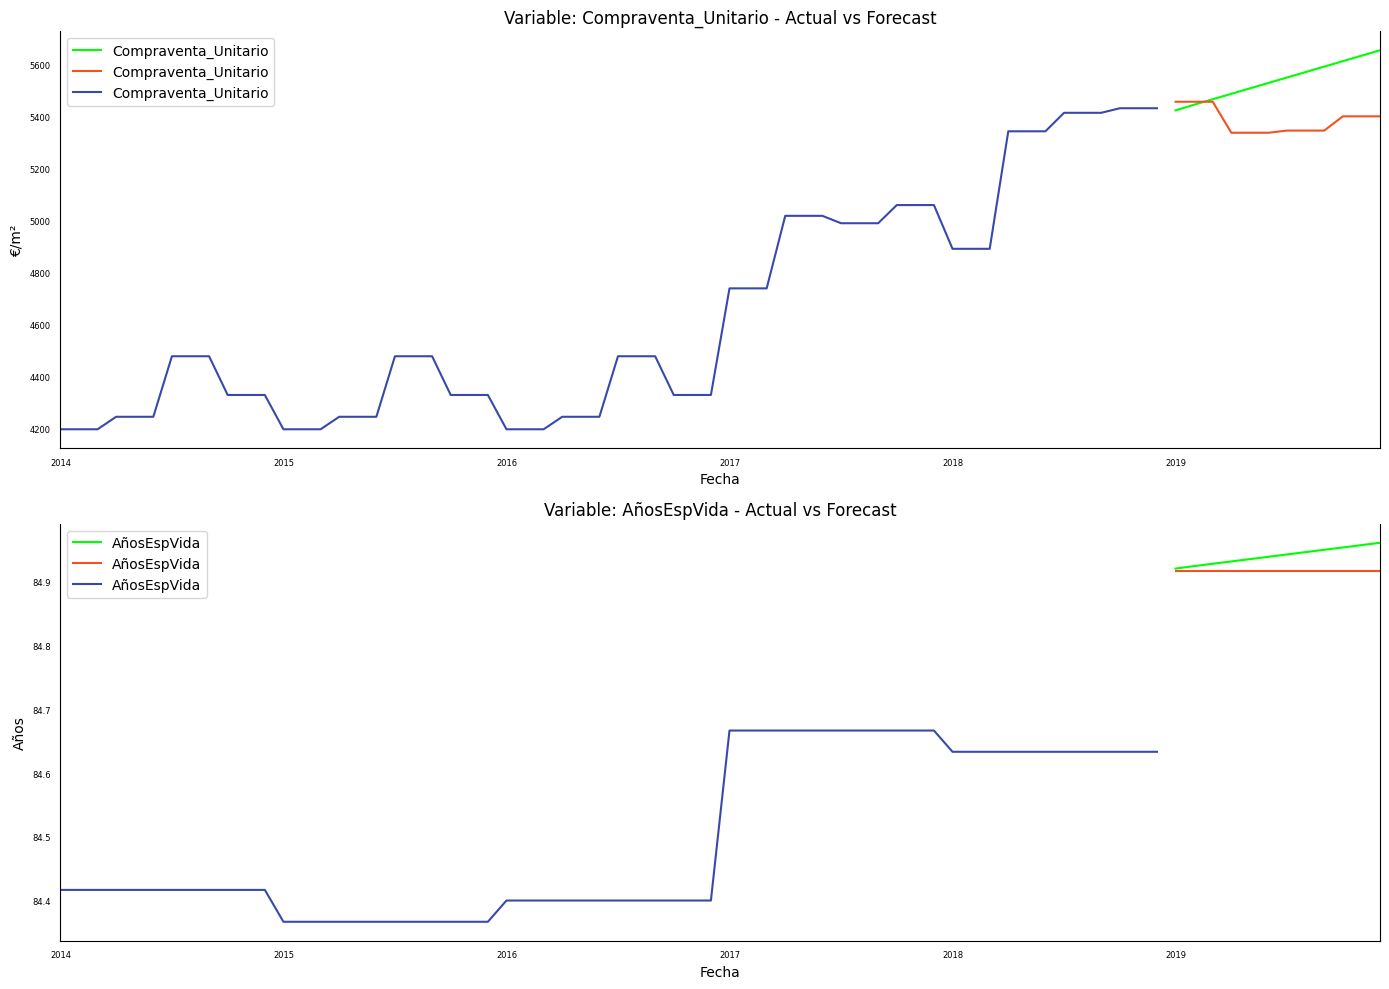

In [63]:
# Actual vs Forecasted Plots
fig, axes = plt.subplots(nrows = int(len(X_train.columns)), ncols = 1, dpi = 100, figsize = (14,10))
mi_lista = ['€/m²', 'Años']

for i, (col,ax) in enumerate(zip(X_train.columns, axes.flatten())):
    res[col].plot(color = '#00FF00', legend = True, ax = ax).autoscale(axis =' x',tight = True)
    X_test[col].plot(color = '#F4511E', legend = True, ax = ax)
    X_train[col].plot(color = '#3949AB', legend = True, ax = ax)

    ax.set_title('Variable: ' + col + ' - Actual vs Forecast')
    ax.set_ylabel(mi_lista[i])  # Establecer etiqueta del eje y
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)

plt.tight_layout()
plt.savefig('actual_forecast.png')
plt.show()

#### Evaluando el modelo

In [64]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [65]:
for i in ['Compraventa_Unitario','AñosEspVida']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(X_test[str(i)] , res[str(i)])

Evaluation metric for Compraventa_Unitario
Evaluation metric results:-
MSE is : 33723.27764154059
MAE is : 161.39078394419312
RMSE is : 183.63898725908012
MAPE is : 3.0082621970214927
R2 is : -13.764346933969888

Evaluation metric for AñosEspVida
Evaluation metric results:-
MSE is : 0.0007559424545819605
MAE is : 0.024409464148123543
RMSE is : 0.027494407696510948
MAPE is : 0.028745198211725463
R2 is : -3.743245727690716e+24



In [66]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('Mean absolute error:', mean_absolute_error(X_test, res))
print('Root mean squared error:', np.sqrt(mean_squared_error(X_test, res)))

Mean absolute error: 80.70759670417063
Root mean squared error: 129.85237463651376


##Conclusiones

Como conclusiones de realizar un analisis de datos forecasting a los datos de distrito de **Sarrià Sant Gervasi** de Barcelona entre las dos series temporales de Compraventa_unitario y AñosEspVida, tenemos que:

- Tal y como se ha comprobado las variables estan correlacionadas

- **MODELO VAR**
  
  - El numero de ordenes establecido en 12, puede ser algo arriesgado, aunque se pueda vislumbrar unos ciclos anules los datos de compraventa. Los datos de esperanza de vida son anuales por lo que no es posible encontrar ciclos
  - Tambien hemos comprobado por el concepto de causalidad de Granger como ninguna serie temporal puede predecir las demas series temporales
  - Los resultados obtenidos en el caso de la serie temporal de Compraventa_Unitario son bastante buenos y se ajustan bastante bien a los datos de test. Mientras que en la serie temporal de AñosEspVida los resultado no son nada concluyentes  respecto a los datos de test

- **MODELO VARMAX**
  - Al implementar autoarima, nos ahorra mucho tiempo de analisis y configura los parámetros con los valores optimos
  - El test de cointegracion nos ha dado positivo, lo que significa que ambas series temporales estan relacionadas en el tiempo.
  - Los resultados obtenidos en ambas series son bastante semejantes a los datos de test

- Si hacemos caso a las evaluaciones de los modelos, el segundo modelo tiene un mejor ajuste con estas dos series temporales.

